In [1]:
!pip install pafy youtube-dl moviepy

     ---------------------------------------- 0.0/388.3 kB ? eta -:--:--
     - -------------------------------------- 10.2/388.3 kB ? eta -:--:--
     -- ---------------------------------- 30.7/388.3 kB 435.7 kB/s eta 0:00:01
     --- --------------------------------- 41.0/388.3 kB 388.9 kB/s eta 0:00:01
     ----- ------------------------------- 61.4/388.3 kB 409.6 kB/s eta 0:00:01
     ----------- ------------------------ 122.9/388.3 kB 717.5 kB/s eta 0:00:01
     ------------- ---------------------- 143.4/388.3 kB 652.5 kB/s eta 0:00:01
     ------------- ---------------------- 143.4/388.3 kB 652.5 kB/s eta 0:00:01
     ------------------ ----------------- 194.6/388.3 kB 692.9 kB/s eta 0:00:01
     ------------------------------- ---- 337.9/388.3 kB 996.0 kB/s eta 0:00:01
     -------------------------------------  378.9/388.3 kB 1.1 MB/s eta 0:00:01
     ------------------------------------ 388.3/388.3 kB 966.9 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing 

In [7]:
pip install opencv-python


   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 991.0 kB/s eta 0:00:40
   ---------------------------------------- 0.1/38.8 MB 1.4 MB/s eta 0:00:28
   ---------------------------------------- 0.3/38.8 MB 2.0 MB/s eta 0:00:20
   ---------------------------------------- 0.4/38.8 MB 2.0 MB/s eta 0:00:20
    --------------------------------------- 0.6/38.8 MB 2.4 MB/s eta 0:00:16
   - -------------------------------------- 1.0/38.8 MB 3.5 MB/s eta 0:00:11
   - -------------------------------------- 1.0/38.8 MB 3.2 MB/s eta 0:00:12
   - -------------------------------------- 1.0/38.8 MB 2.7 MB/s eta 0:00:14
   - -------------------------------------- 1.1/38.8 MB 2.5 MB/s eta 0:00:16
   - -------------------------------------- 1.2/38.8 MB 2.7 MB/s eta 0:00:14
   - -------------------------------------- 1.3/38.8 MB 2.6 MB/s eta 0:00:15
   - ------

In [8]:
#importing required libraries
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline


from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [9]:
seed_constant =27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [10]:
#downloading UCF50 dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
#extracting the rar file
!unrar x UCF50.rar

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unrar' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
#creating the matlotlib figure and specifying the size of fig
plt.figure(figsize=(20,20))
all_classes_names =os.listdir('UCF50')
random_range =random.sample(range(len(all_classes_names)),20)
for counter,random_index in enumerate(random_range,1):
  selected_class_Name = all_classes_names[random_index]
  video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
  selected_video_file_name = random.choice(video_files_names_list)
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/ {selected_video_file_name}')
  _, bgr_frame = video_reader.read()
  # Check if the video file is opened successfully
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
  _, bgr_frame = video_reader.read()
  video_reader.release()
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class_Name, (10,30),cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255),2)
  plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis('off')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'UCF50'

<Figure size 2000x2000 with 0 Axes>

In [6]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64,64
SEQUENCE_LENGTH = 20
DATASET_DIR ="UCF50"
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [33]:
def frames_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    success, frame = video_reader.read()
    if not success:
      break
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame/255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list


In [34]:
def create_dataset():
  features = []
  labels = []
  video_files_paths = []
  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data of Class:{class_name}')
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
      frames = frames_extraction(video_file_path)
      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)
  features = np.asarray(features)
  labels = np.array(labels)
  return features, labels, video_files_paths

In [35]:
#create a dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class:WalkingWithDog
Extracting Data of Class:TaiChi
Extracting Data of Class:Swing
Extracting Data of Class:HorseRace


In [36]:
one_hot_encoded_labels = to_categorical(labels)

In [11]:
#split the data
features_train, features_test, labels_train, labels_test = train_test_split(features,one_hot_encoded_labels,test_size=0.25,shuffle = True, random_state =seed_constant)

In [37]:
def create_LRCN_model():
    # We will use a Sequential model for model construction.
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))


    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [38]:
LRCN_model = create_LRCN_model()
print("model successfully created")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 20, 4, 4, 32)     

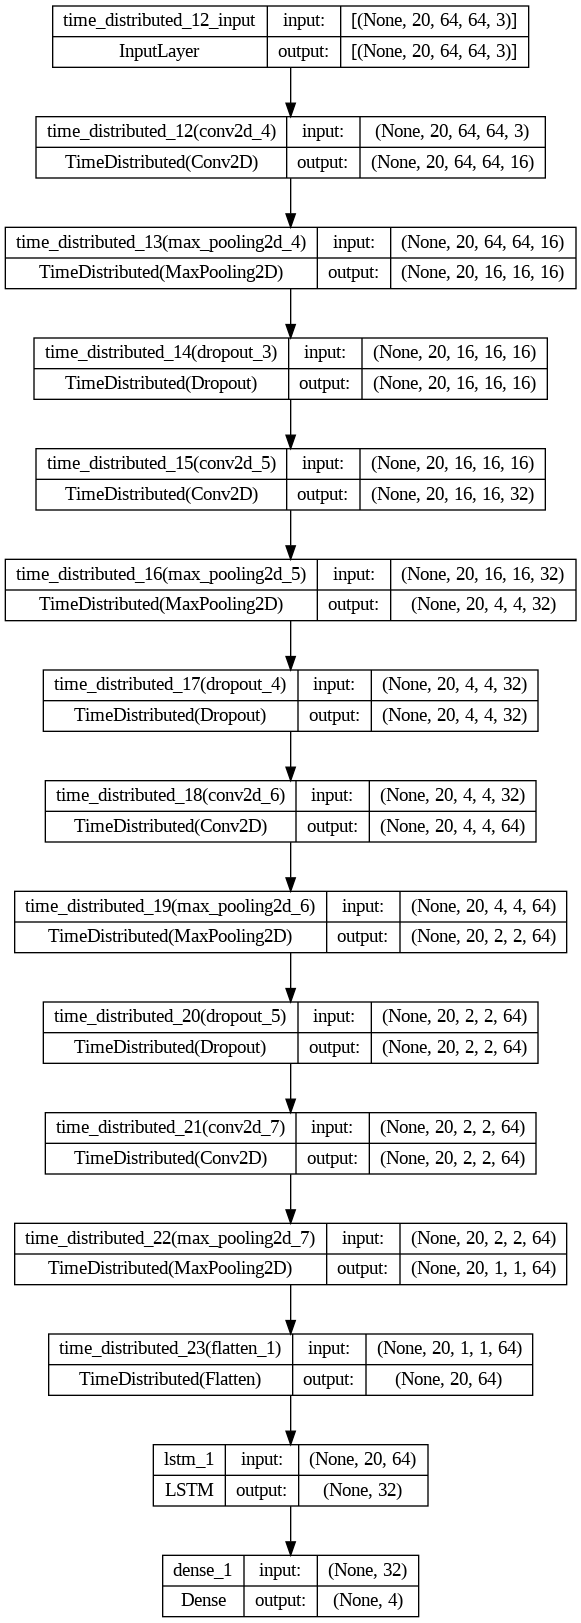

In [39]:
plot_model(LRCN_model, to_file='LRCN_model_structure_plot.png', show_shapes=True, show_layer_names=True)


In [40]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss',patience = 15, mode ='min',restore_best_weights = True)
LRCN_model.compile(loss ='categorical_crossentropy',optimizer ='Adam',metrics =['accuracy'])
LRCN_model_training_history = LRCN_model.fit(x=features_train,y =labels_train,epochs=70,batch_size=4,
                                             shuffle= True,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/70
73/73 [==============================] - 17s 182ms/step - loss: 1.3924 - accuracy: 0.2774 - val_loss: 1.3726 - val_accuracy: 0.3562
Epoch 2/70
73/73 [==============================] - 13s 177ms/step - loss: 1.3407 - accuracy: 0.3459 - val_loss: 1.3562 - val_accuracy: 0.3562
Epoch 3/70
73/73 [==============================] - 12s 170ms/step - loss: 1.2004 - accuracy: 0.4863 - val_loss: 1.3371 - val_accuracy: 0.3562
Epoch 4/70
73/73 [==============================] - 13s 176ms/step - loss: 1.0385 - accuracy: 0.5856 - val_loss: 1.3277 - val_accuracy: 0.3425
Epoch 5/70
73/73 [==============================] - 13s 175ms/step - loss: 0.8773 - accuracy: 0.6199 - val_loss: 0.7691 - val_accuracy: 0.6712
Epoch 6/70
73/73 [==============================] - 13s 175ms/step - loss: 0.7304 - accuracy: 0.6918 - val_loss: 0.7554 - val_accuracy: 0.6301
Epoch 7/70
73/73 [==============================] - 13s 177ms/step - loss: 0.7074 - accuracy: 0.7055 - val_loss: 0.6071 - val_accuracy: 0.7808

In [41]:
model_evaluation_history = LRCN_model.evaluate(features_test,labels_test)

4/4 [==============================] - 1s 369ms/step - loss: 0.5329 - accuracy: 0.8443


In [42]:
model_evaluation_loss, model_evaluation_accuarcy = model_evaluation_history
date_time_format ='%Y_%n_%d__%H_%M_%S'
current_date_time_dt =dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_file_name = f'LRCN_model___Date_Time{current_date_time_string}___Loss_{model_evaluation_loss}___Accuaracy_{model_evaluation_accuarcy}.h5'
LRCN_model.save(model_file_name)

In [43]:
def plot_metric(model_training_history,metric_name_1,metric_name_2,plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]
  epochs = range(len(metric_value_1))
  plt.plot(epochs,metric_value_1,'blue',label = metric_name_1)
  plt.plot(epochs,metric_value_2,'red',label = metric_name_2)
  plt.title(str(plot_name))
  plt.legend()


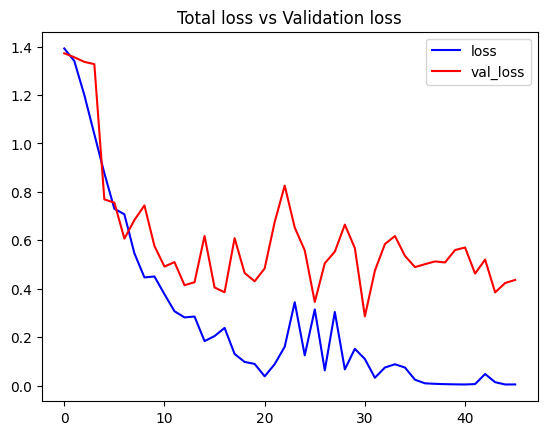

In [44]:
plot_metric(LRCN_model_training_history,'loss', 'val_loss','Total loss vs Validation loss')

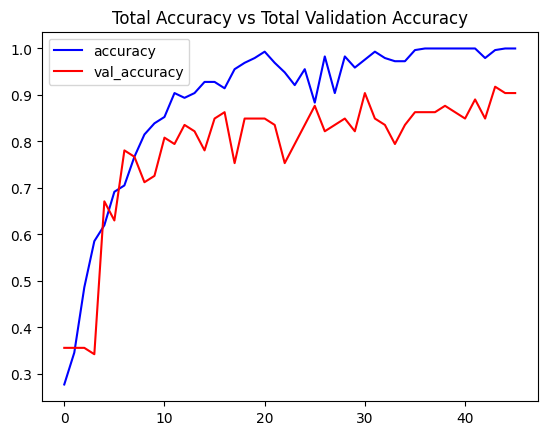

In [45]:
plot_metric(LRCN_model_training_history,'accuracy','val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [46]:
!pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 15.7 MB/s eta 0:00:00


In [47]:
import yt_dlp as youtube_dl
def download_youtube_videos(youtube_video_url, output_directory):
  video = pafy.new(youtube_video_url)
  title = video.title
  video_best = video.getbest()
  output_file_path = f'{output_directory}/{title}.mp4'
  video_best.download(filepath = output_file_path, quiet = True)
  return title

In [48]:
import os

In [49]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 521.5 kB/s eta 0:00:00


In [50]:
import os
import yt_dlp as youtube_dl
from pytube import YouTube

# Get the video URL from the user
video_url = input("Enter URL: ")

# Create the directory for storing downloaded videos
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# Get the highest resolution video stream
video = YouTube(video_url)
video_stream = video.streams.get_highest_resolution()

# Download the video
video_stream.download(output_path=test_videos_directory)

Enter URL: https://www.youtube.com/watch?v=8u0qjmHIOcE


'/content/test_videos/Test Video.mp4'

In [51]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
      # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [52]:
from pytube import YouTube
from moviepy.editor import VideoFileClip

In [53]:
input_video_file_path = '/content/test_videos/Test Video.mp4'

In [54]:
output_video_file_path = "test_videos/output.mp4"
# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 35ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  99%|█████████▉| 861/867 [00:02<00:00, 326.63it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file test_videos/output.mp4, 360000 bytes wanted but 0 bytes read,at frame 866/867, at time 31.04/31.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4
